# Content Based Filtering

This algorithm recommends movies which are similar to the ones that user liked before.

For example, if a person has liked the movie “Inception”, then this algorithm will recommend movies that fall under the same genre. 

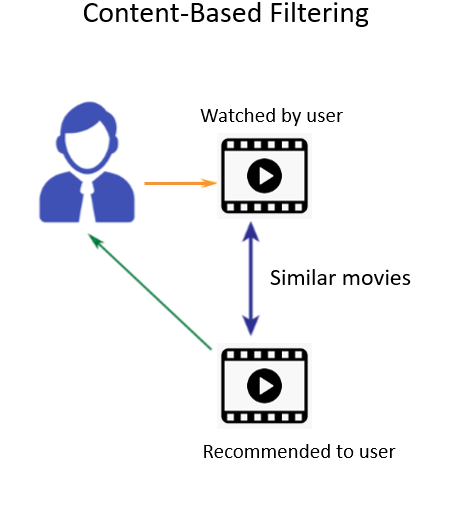

### Dataset

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 

## Preprocessing

First, let's import all the required modules:

In [1]:
import pandas as pd
import numpy as np
from surprise import accuracy
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
movies_df = pd.read_csv(r'C:\Users\P Sai Deekshith\Recommender Systems\ml-100k\movies.csv')

ratings_df = pd.read_csv(r'C:\Users\P Sai Deekshith\Recommender Systems\ml-100k\ratings.csv')


In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Extract the year from Title column to a separate column:

In [5]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

movies_df.head(50)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


Splitting the genre:

In [6]:
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


#### On Hot Encoding

In [7]:
moviesWithGenres_df = movies_df.copy()

for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
        
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Removing timestamp column from ratings dataframe: 

In [8]:
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### User Input: 

In [9]:
# userInput = [
#             {'title':'Breakfast Club, The', 'rating':5},
#             {'title':'Toy Story', 'rating':3.5},
#             {'title':'Jumanji', 'rating':2},
#             {'title':'Pulp Fiction', 'rating':5},
#             {'title':'Akira', 'rating':4.5}
#          ] 
# inputMovies = pd.DataFrame(userInput)
# inputMovies
userInput = [
            {'title':'Grumpier Old Men', 'rating':3.180094},
            {'title':'Toy Story', 'rating':3.894802},
            {'title':'Jumanji', 'rating':3.221086},
            {'title':'Waiting to Exhale', 'rating':2.879727},
            {'title':'Father of the Bride Part II', 'rating':3.080811}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies
# 1	3.894802
# 2	3.221086
# 3	3.180094
# 4	2.879727
# 5	3.080811

,title,rating
0,Grumpier Old Men,3.180094
1,Toy Story,3.894802
2,Jumanji,3.221086
3,Waiting to Exhale,2.879727
4,Father of the Bride Part II,3.080811


Making a DataFrame out of UserInput by adding movieId to it.

In [10]:
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
inputMovies = pd.merge(inputId, inputMovies)
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)

inputMovies.head()

,movieId,title,rating
0,1,Toy Story,3.894802
1,2,Jumanji,3.221086
2,3,Grumpier Old Men,3.180094
3,4,Waiting to Exhale,2.879727
4,5,Father of the Bride Part II,3.080811


Creating a boolean matrix for the userInput based on the genre:

In [11]:
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies = userMovies.reset_index(drop=True)
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)

userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have to learn from input's preference and try to predict the ratings.

We can do this by using the input's ratings and multiplying them into the input's genre table and summing up the resulting table by column.
This is called dot product between a matrix and a vector.



In [12]:
inputMovies['rating']

0    3.894802
1    3.221086
2    3.180094
3    2.879727
4    3.080811
Name: rating, dtype: float64

In [13]:
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
userProfile

Adventure              7.115888
Animation              3.894802
Children               7.115888
Comedy                13.035434
Fantasy                7.115888
Romance                6.059821
Drama                  2.879727
Action                 0.000000
Crime                  0.000000
Thriller               0.000000
Horror                 0.000000
Mystery                0.000000
Sci-Fi                 0.000000
War                    0.000000
Musical                0.000000
Documentary            0.000000
IMAX                   0.000000
Western                0.000000
Film-Noir              0.000000
(no genres listed)     0.000000
dtype: float64

Now, we have formed the User's Profile.

Extracting the genre table from the original dataframe.

In [14]:
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Computing the weighted verage of every movie based on the input profile:

In [15]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.810673
2    0.452114
3    0.404411
4    0.465400
5    0.276072
dtype: float64

In [16]:
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
recommendationTable_df.head()

movieId
92348     0.939011
56152     0.939011
4306      0.939011
84637     0.939011
134853    0.871661
dtype: float64

### The Final Recommendation Table

In [17]:
movies_df = movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(100).keys())]
movies_df.head(20)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
222,258,"Kid in King Arthur's Court, A","[Adventure, Children, Comedy, Fantasy, Romance]",1995
478,546,Super Mario Bros.,"[Action, Adventure, Children, Comedy, Fantasy,...",1993
506,588,Aladdin,"[Adventure, Animation, Children, Comedy, Musical]",1992
534,631,All Dogs Go to Heaven 2,"[Adventure, Animation, Children, Fantasy, Musi...",1996
559,673,Space Jam,"[Adventure, Animation, Children, Comedy, Fanta...",1996
578,709,Oliver & Company,"[Adventure, Animation, Children, Comedy, Musical]",1988
769,1011,Herbie Rides Again,"[Children, Comedy, Fantasy, Romance]",1974
812,1064,Aladdin and the King of Thieves,"[Animation, Children, Comedy, Fantasy, Musical...",1996
899,1197,"Princess Bride, The","[Action, Adventure, Comedy, Fantasy, Romance]",1987


### Evaluation

We use RMSE(Root Mean Square Error) to evaluate the recommendations.

Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

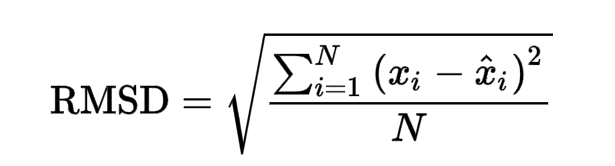

In [18]:
recommended_rating = pd.DataFrame(recommendationTable_df)
recommended_rating['movieId'] = recommended_rating.index
recommended_rating.reset_index(drop=True, inplace=True)
recommendationTable_df.reset_index(drop=True, inplace=True)
recommended_rating['recommended_ratings'] = recommendationTable_df
recommended_rating.head()

,0,movieId,recommended_ratings
0,0.939011,92348,0.939011
1,0.939011,56152,0.939011
2,0.939011,4306,0.939011
3,0.939011,84637,0.939011
4,0.871661,134853,0.871661


In [19]:
recommended_rating.drop([0], axis=1, inplace=True)
recommended_rating.head()

,movieId,recommended_ratings
0,92348,0.939011
1,56152,0.939011
2,4306,0.939011
3,84637,0.939011
4,134853,0.871661


In [20]:
finalEvaluationTable = recommended_rating
finalEvaluationTable['recommended_ratings'] *= 5
finalEvaluationTable.head()

,movieId,recommended_ratings
0,92348,4.695057
1,56152,4.695057
2,4306,4.695057
3,84637,4.695057
4,134853,4.358307


In [21]:
finalEvaluationTable = finalEvaluationTable.sort_values('movieId')
finalEvaluationTable.head()

,movieId,recommended_ratings
17,1,4.053364
849,2,2.260569
1579,3,2.022055
836,4,2.326998
2963,5,1.380362


In [22]:
true_ratings = ratings_df.groupby(ratings_df['movieId']).mean()
true_ratings.drop('userId', axis=1, inplace=True)
true_ratings.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [23]:
recommendedMovieId = finalEvaluationTable['movieId']

In [24]:
true_ratings['movieId'] = true_ratings.index
true_ratings.reset_index(drop=True, inplace=True)
true_ratings = true_ratings[true_ratings.movieId.isin(recommendedMovieId)]['rating']

true_ratings.head()

0    3.920930
1    3.431818
2    3.259615
3    2.357143
4    3.071429
Name: rating, dtype: float64

In [25]:
true_ratings = pd.DataFrame(true_ratings)
true_ratings.reset_index(drop=True, inplace=True)
true_ratings.head()

,rating
0,3.920930
1,3.431818
2,3.259615
3,2.357143
4,3.071429


In [26]:
finalEvaluationTable.head()
finalEvaluationTable.reset_index(drop=True, inplace=True)
finalEvaluationTable['true_ratings'] = true_ratings
#finalEvaluationTable.reset_index(drop=True, inplace=True)
finalEvaluationTable.dropna(inplace=True)
finalEvaluationTable.head()

,movieId,recommended_ratings,true_ratings
0,1,4.053364,3.920930
1,2,2.260569,3.431818
2,3,2.022055,3.259615
3,4,2.326998,2.357143
4,5,1.380362,3.071429


In [27]:
finalEvaluationTable = finalEvaluationTable[finalEvaluationTable.movieId.isin(inputMovies.movieId)]

In [30]:
def rmseContentBased():   
    rmse = sqrt(mean_squared_error(finalEvaluationTable['true_ratings'], finalEvaluationTable['recommended_ratings']))
    print("The RMSE value is : " + str(rmse))
    return rmse

In [33]:
rmseContentBased()

The RMSE value is : 1.0753169785884567


1.0753169785884567

### Advantages and Disadvantages of Content-Based Filtering

##### Advantages

-   Learns user's preferences
-   Highly personalized for the user

##### Disadvantages

-   Doesn't take into account what others think of the item, so low quality item recommendations might happen
-   Extracting data is not always intuitive
-   Determining what characteristics of the item the user dislikes or likes is not always obvious
